In [1]:
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/Capstone'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel('/content/drive/My Drive/input_data.xlsx', sheet_name='Sheet1')

# EDA

In [3]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [4]:
print(f'Database shape: ',df.shape)
print(df.info())

Database shape:  (8500, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB
None


In [5]:
df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [6]:
print(f'Unique assignment groups: ',df['Assignment group'].nunique())
print(f'Unique callers: ',df['Caller'].nunique())
print(f'Unique short descriptions: ',df['Short description'].nunique())

Unique assignment groups:  74
Unique callers:  2950
Unique short descriptions:  7481


In [7]:
df["Merge_Desc"]=df["Short description"].astype(str)+df["Description"].astype(str) 
df.head(3)

,Short description,Description,Caller,Assignment group,Merge_Desc
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn\r\n\r\nreceived from: eylqg...


In [8]:
groups = df.groupby(['Assignment group']).size().reset_index(name='counts') 

profile = round(groups.describe(),2)
profile.loc['Skew'] = round(groups.skew(),2).tolist()

profile.transpose()

,count,mean,std,min,25%,50%,75%,max,Skew
counts,74.0,114.86,465.75,1.0,5.25,26.0,84.0,3976.0,8.04


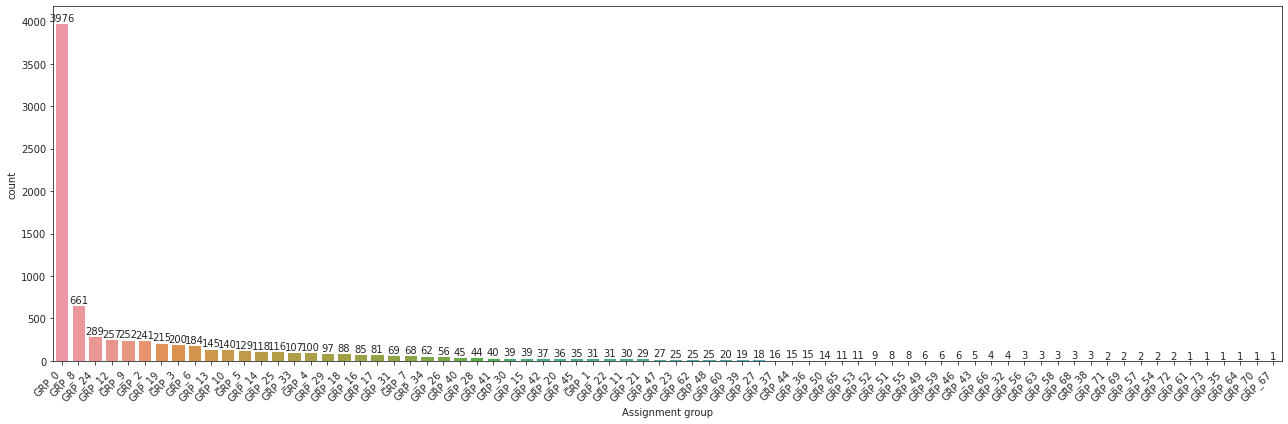

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings. filterwarnings('ignore')
sns.set_style('ticks')

fig = plt.figure(figsize=(18,6))
ax = sns.countplot(df['Assignment group'], order = df['Assignment group'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

for p in ax.patches:
  ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()

Text(0.5, 1.0, 'Ticket Distribution across groups')

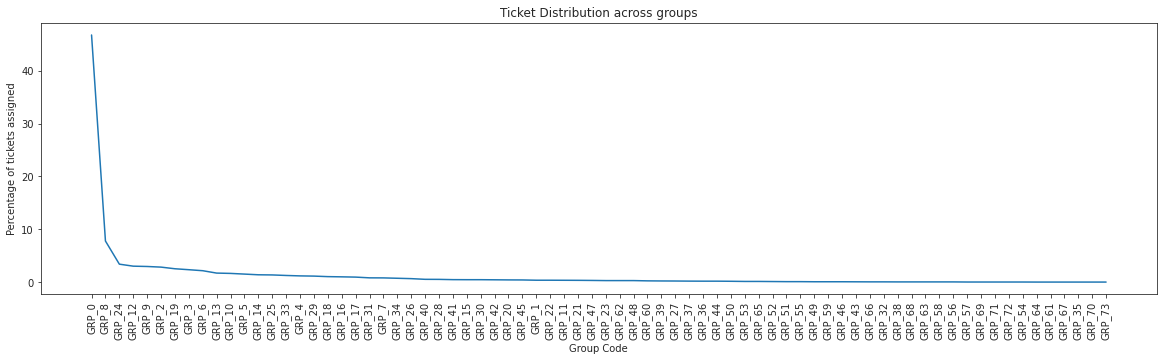

In [10]:
groups["percentage"] = round((groups["counts"]/df.shape[0])*100,2)
groups.sort_values(["percentage"], axis=0, ascending=False, inplace=True)

plt.subplots(figsize = (20,5))
 
plt.plot(groups["Assignment group"], groups["percentage"]) 
plt.xlabel('Group Code') 
plt.ylabel('Percentage of tickets assigned') 
plt.xticks(rotation=90)
plt.title('Ticket Distribution across groups')

Text(0.5, 1.0, 'Incident Distribution For Groups except GRP_0')

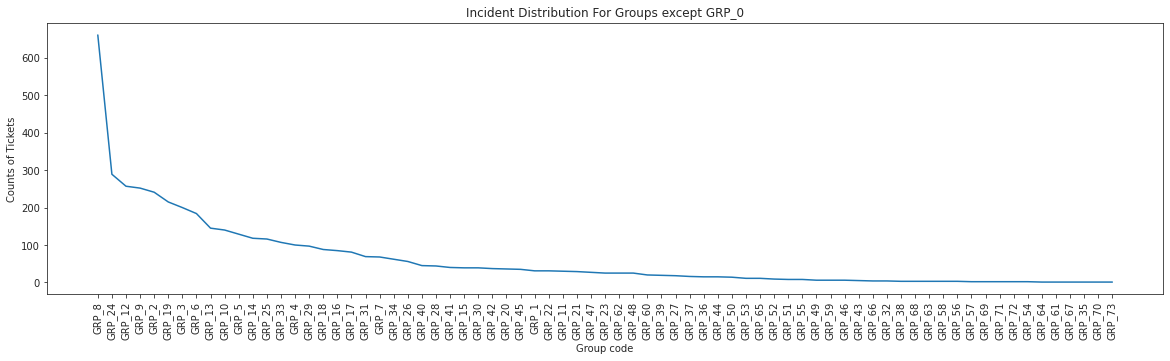

In [11]:
df_n0 = groups[groups["Assignment group"] != 'GRP_0']

plt.subplots(figsize = (20,5))
plt.plot(df_n0["Assignment group"], df_n0["counts"]) 
plt.xlabel('Group code') 
plt.ylabel('Counts of Tickets') 
plt.xticks(rotation=90)
plt.title('Incident Distribution For Groups except GRP_0')

# Data Preprocessing


In [12]:
df['Description'] = df['Description'].astype(str)

In [13]:
!pip install langdetect

#Lets encode the string, to make it easier to be passed to language detection api.
def fn_decode_to_ascii(df):
  text = df.encode().decode('utf-8').encode('ascii', 'ignore')
  return text.decode("utf-8") 

In [14]:
from langdetect import detect
    
def fn_lan_detect(df):                                        
   try:                                                          
      return detect(df)                                      
   except:                                                       
      return 'no'                                                  

df['language'] = df['Merge_Desc'].apply(fn_lan_detect)

In [15]:
df.head()

,Short description,Description,Caller,Assignment group,Merge_Desc,language
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...,en
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...,en
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn\r\n\r\nreceived from: eylqg...,en
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool pageunable to access ...,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,no


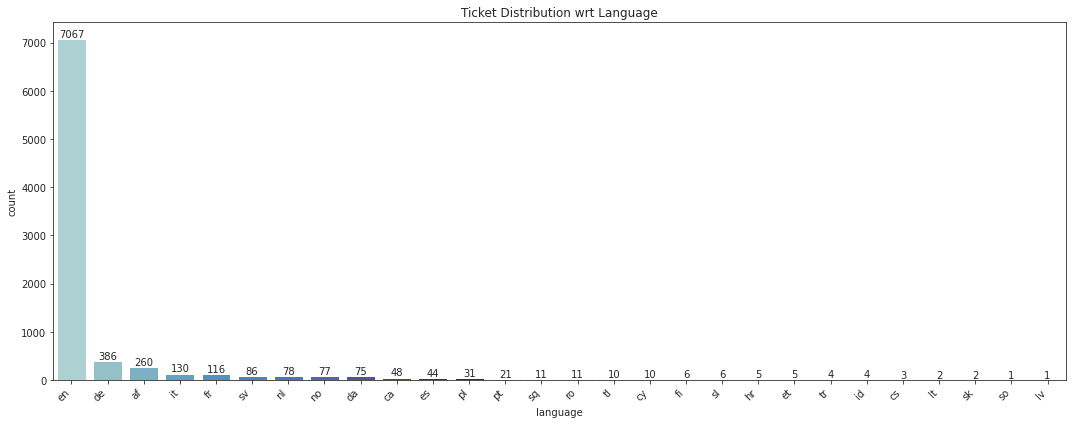

In [16]:
fig = plt.figure(figsize=(15,6))
ax = sns.countplot(df['language'], order = df['language'].value_counts().index,palette='icefire')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for p in ax.patches:
  ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.title('Ticket Distribution wrt Language')
plt.tight_layout()

In [17]:
!pip install googletrans==3.1.0a0

import googletrans
from googletrans import Translator

# Function to translate the text to english.
def fn_translate(df,lang):
  try:
    if lang == 'en':
        return df
    else:
        return translator.translate(df).text
  except:
    return df
    
    
df['English_Description'] = df.apply(lambda x: fn_translate(x['Merge_Desc'], x['language']), axis=1)

In [18]:
df.head(2)

,Short description,Description,Caller,Assignment group,Merge_Desc,language,English_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...,en,login issue-verified user details.(employee# &...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...,en,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...


In [19]:
df_new = df.drop(['Short description','Description','Caller','Merge_Desc'],axis=1)
df_new.English_Description=df_new.English_Description.astype(str)
df_new.head()

,Assignment group,language,English_Description
0,GRP_0,en,login issue-verified user details.(employee# &...
1,GRP_0,en,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...
2,GRP_0,en,cant log in to vpn\r\n\r\nreceived from: eylqg...
3,GRP_0,en,unable to access hr_tool pageunable to access ...
4,GRP_0,no,skype error skype error


# Data cleaning

In [20]:
import string
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from textblob import Word

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text=text.replace(('first name: ').lower(),'firstname')
    text=text.replace(('last name: ').lower(),'lastname')
    text=text.replace(('received from:').lower(),'')
    text=text.replace('email:','')
    text=text.replace('email address:','') 
    index1=text.find('from:')
    index2=text.find('\nsddubject:')
    text=text.replace(text[index1:index2],'')
    index3=text.find('[cid:image')
    index4=text.find(']')
    text=text.replace(text[index3:index4],'')
    text=text.replace('subject:','')
    text=text.replace('received from:','')
    text=text.replace('this message was sent from an unmonitored email address', '')
    text=text.replace('please do not reply to this message', '')
    text=text.replace('monitoring_tool@company.com','MonitoringTool')
    text=text.replace('select the following link to view the disclaimer in an alternate language','')
    text=text.replace('description problem', '') 
    text=text.replace('steps taken far', '')
    text=text.replace('customer job title', '')
    text=text.replace('sales engineer contact', '')
    text=text.replace('description of problem:', '')
    text=text.replace('steps taken so far', '')
    text=text.replace('please do the needful', '')
    text=text.replace('please note that ', '')
    text=text.replace('please find below', '')
    text=text.replace('date and time', '')
    text=text.replace('kindly refer mail', '')
    text=text.replace('name:', '')
    text=text.replace('language:', '')
    text=text.replace('customer number:', '')
    text=text.replace('telephone:', '')
    text=text.replace('summary:', '')
    text=text.replace('sincerely', '')
    text=text.replace('company inc', '')
    text=text.replace('importance:', '')
    text=text.replace('hello', '')
    text=text.replace('hallo', '')
    text=text.replace('hi it team', '')
    text=text.replace('hi team', '')
    text=text.replace('hi', '')
    text=text.replace('best', '')
    text=text.replace('kind', '')
    text=text.replace('regards', '')
    text=text.replace('good morning', '')
    text=text.replace('please', '')
    text=text.replace('regards', '')

    text = re.sub(r'\S+@\S+', '', text)
    custom_punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\r\n', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[\w.+-]+@[a-z\d-]+\.[a-z\d.-]+','',text)


    text = text.lower()
    return text

In [21]:
df_new['cleaned_description'] = df_new['English_Description'].apply(lambda x: clean_text(x))
df_new.drop(['English_Description'],axis=1,inplace=True)
df_new['cleaned_description'].head()

0    login issueverified user detailsemployee  mana...
1    outlook  teammy meetingsskype meetings etc are...
2           cant log in to vpn i cannot log on to vpn 
3    unable to access hrtool pageunable to access h...
4                             skype error skype error 
Name: cleaned_description, dtype: object

In [22]:
import nltk
nltk.download('stopwords')
## Removal of Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
df_new['cleaned_description'] = df_new['cleaned_description'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
df_new['cleaned_description'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    login issueverified user detailsemployee manag...
1    outlook teammy meetingsskype meetings etc appe...
2                          cant log vpn cannot log vpn
3    unable access hrtool pageunable access hrtool ...
4                              skype error skype error
Name: cleaned_description, dtype: object

In [23]:
## Lemmatization
import nltk
nltk.download('wordnet')

from textblob import Word
df_new['cleaned_description']= df_new['cleaned_description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))
df_new['cleaned_description'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    login issueverified user detailsemployee manag...
1    outlook teammy meetingsskype meeting etc appea...
2                          cant log vpn cannot log vpn
3    unable access hrtool pageunable access hrtool ...
4                              skype error skype error
Name: cleaned_description, dtype: object

In [24]:
#Installing FuzzyWuzzy
!pip install fuzzywuzzy

#Import
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

groups = df_new.groupby(['Assignment group'], as_index = False).agg({'cleaned_description': ' '.join})

similarity_matrix = np.zeros((groups.shape[0]-1,groups.shape[0]-1))

for i in np.arange(0, (groups.shape[0]-1)):
  for j in np.arange(0,(groups.shape[0]-1)):
    similarity_matrix[i][j] = fuzz.token_set_ratio(groups['cleaned_description'].iloc[i+1],groups['cleaned_description'].iloc[j+1])

np.fill_diagonal(similarity_matrix, 0)

similarity_matrix = pd.DataFrame(similarity_matrix)
max_fuzz = pd.DataFrame(similarity_matrix.max(axis = 1), columns = ['Max'])
max_fuzz['Row'] = similarity_matrix.idxmax(axis = 1)

groups['Merged_Group'] = groups['Assignment group']

for i in np.arange(1,groups.shape[0]):
  groups.loc[i,'Max_Fuzz_Row'] = max_fuzz.loc[i-1]['Row'] + 1
  groups.loc[i,'Max_Fuzz_Score'] = max_fuzz.loc[i-1]['Max']
  if groups.loc[i,'Max_Fuzz_Score'] > 70:
    groups.loc[i,'Merged_Group'] = groups.loc[groups.loc[i,'Max_Fuzz_Row'],'Merged_Group']
  else: 
    pass

groups.loc[0,'Max_Fuzz_Row'] = 0
groups.loc[0,'Max_Fuzz_Score'] = 100

In [25]:
print(f'Unique merged groups: ',groups['Merged_Group'].nunique())

Unique merged groups:  43


In [26]:
group_t = groups[['Assignment group','Merged_Group']]
df_m = df_new.merge(group_t, on = ['Assignment group'], how = 'left')

In [28]:
df_m.head()

,Assignment group,language,cleaned_description,Merged_Group
0,GRP_0,en,login issueverified user detailsemployee manag...,GRP_0
1,GRP_0,en,outlook teammy meetingsskype meeting etc appea...,GRP_0
2,GRP_0,en,cant log vpn cannot log vpn,GRP_0
3,GRP_0,en,unable access hrtool pageunable access hrtool ...,GRP_0
4,GRP_0,no,skype error skype error,GRP_0


In [29]:
df_fw = df_m.loc[(df_m['Assignment group'] != df_m['Merged_Group'])]

In [30]:
print(df_fw)

     Assignment group  ... Merged_Group
17              GRP_3  ...       GRP_35
43              GRP_5  ...       GRP_57
47              GRP_6  ...        GRP_9
50              GRP_8  ...        GRP_9
57              GRP_6  ...        GRP_9
...               ...  ...          ...
8490           GRP_29  ...       GRP_57
8493           GRP_10  ...       GRP_57
8494            GRP_3  ...       GRP_35
8495           GRP_29  ...       GRP_57
8498           GRP_62  ...       GRP_35

[3071 rows x 4 columns]


# Visualizing data after merging

Text(0.5, 1.0, 'Ticket Distribution across groups')

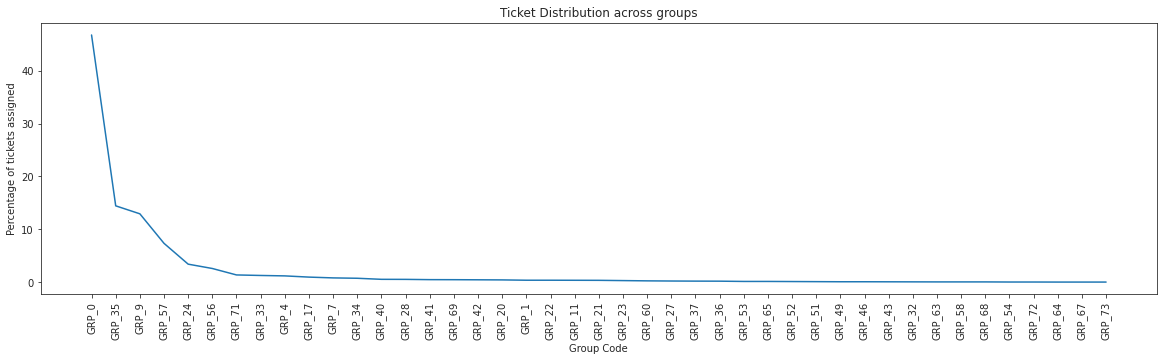

In [31]:
groups = df_m.groupby(['Merged_Group']).size().reset_index(name='counts') 

groups["percentage"] = round((groups["counts"]/df_m.shape[0])*100,2)
groups.sort_values(["percentage"], axis=0, ascending=False, inplace=True)

plt.subplots(figsize = (20,5))
 
plt.plot(groups["Merged_Group"], groups["percentage"]) 
plt.xlabel('Group Code') 
plt.ylabel('Percentage of tickets assigned') 
plt.xticks(rotation=90)
plt.title('Ticket Distribution across groups')

# Handling data imbalance

In [32]:
dfz = df_m[(df_m['Merged_Group'] == 'GRP_0')]
dfz.head()

,Assignment group,language,cleaned_description,Merged_Group
0,GRP_0,en,login issueverified user detailsemployee manag...,GRP_0
1,GRP_0,en,outlook teammy meetingsskype meeting etc appea...,GRP_0
2,GRP_0,en,cant log vpn cannot log vpn,GRP_0
3,GRP_0,en,unable access hrtool pageunable access hrtool ...,GRP_0
4,GRP_0,no,skype error skype error,GRP_0


In [33]:
dfn0 = df_m[(df_m['Merged_Group'] != 'GRP_0')]
dfn0.head()

,Assignment group,language,cleaned_description,Merged_Group
6,GRP_1,en,event criticalcompanycom value mountpoint thre...,GRP_1
17,GRP_3,en,undocking pc screen come backwhen undocking pc...,GRP_35
32,GRP_4,en,duplication network address gentlesi two devic...,GRP_4
43,GRP_5,en,reroute job issue need resolved today printer ...,GRP_57
47,GRP_6,en,job failed jobscheduler monitoringtooljob fail...,GRP_9


In [34]:
maxOthers = dfn0["Merged_Group"].value_counts().max()
maxOthers

1227

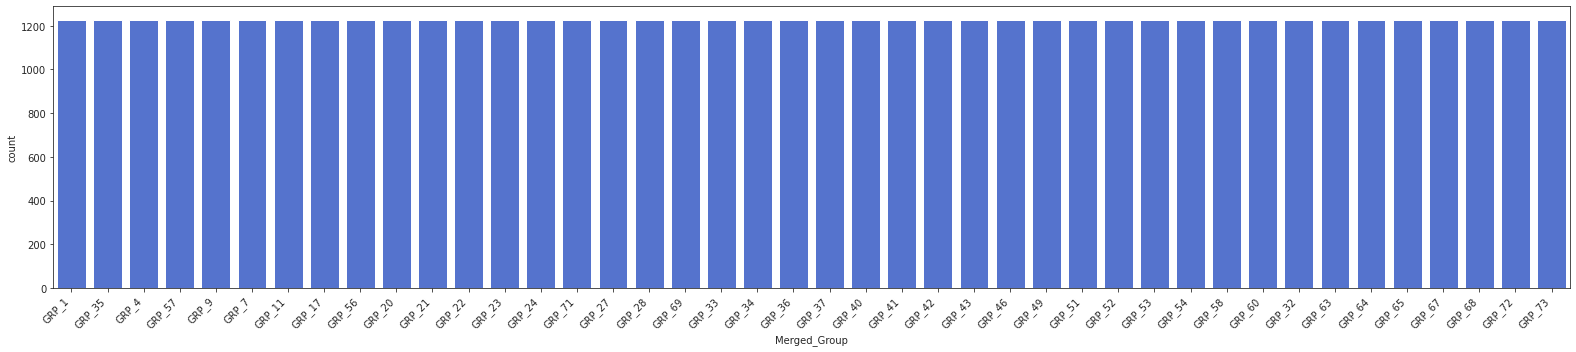

In [35]:
# Upsampling non zero groups

from sklearn.utils import resample
dfn0_resampled = dfn0[0:0]
for grp in dfn0['Merged_Group'].unique():
    Grpn0 = dfn0[dfn0['Merged_Group'] == grp]
    resampled = resample(Grpn0, replace=True, n_samples=int(maxOthers), random_state=123)
    dfn0_resampled = dfn0_resampled.append(resampled)

Grpn0 = pd.concat([dfz,dfn0_resampled])
Grpn0.reset_index(inplace=True)

descending_order = dfn0_resampled['Merged_Group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Merged_Group', data=dfn0_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [36]:
df_resampled = pd.concat([dfz,dfn0_resampled])
df_resampled.reset_index(inplace=True)

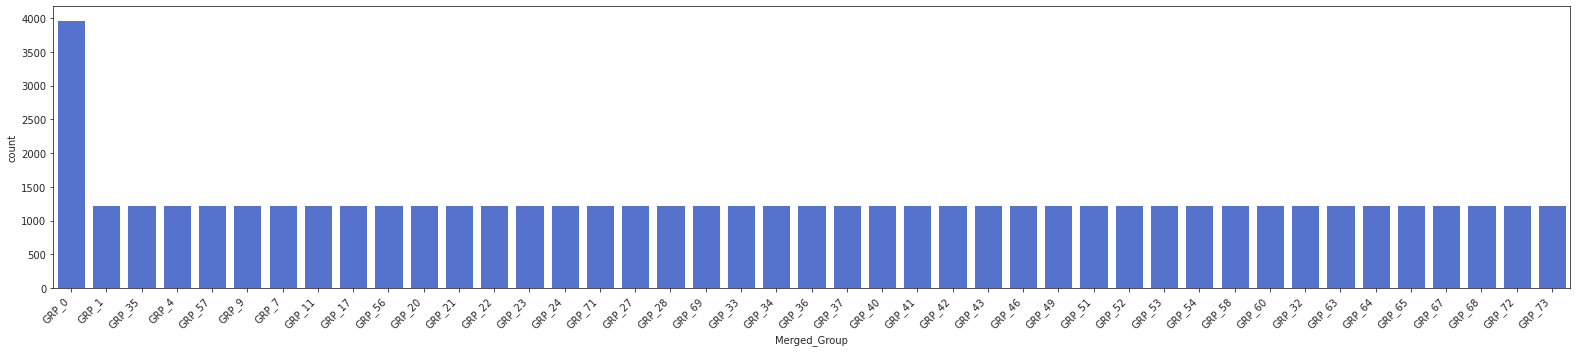

In [37]:
descending_order = df_resampled['Merged_Group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Merged_Group', data=df_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Word vectorization

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_features = 10000
maxlen = 200
embedding_size = 200

tokenizer = Tokenizer(num_words = max_features, split= ' ')
tokenizer.fit_on_texts(df_resampled['cleaned_description'].values)

num_words = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(df_resampled['cleaned_description'].values)
X = pad_sequences(X, maxlen = maxlen, padding = 'post', value = 0)

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

y = df_resampled['Merged_Group']
Xs = scaler.fit_transform(X)

# Train test set preparation

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
  
label_encoder = preprocessing.LabelEncoder() 
y= label_encoder.fit_transform(y) 
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(Xs,y, test_size = 0.10, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49959, 200), (5551, 200), (49959, 43), (5551, 43))

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 25
X = pad_sequences(X, maxlen = maxlen, padding = 'post', value = 0)

# ML Models

In [41]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

import warnings
warnings.simplefilter(action = 'ignore')

In [43]:
#Naive Bayes
GNB = GaussianNB().fit(X_train,y_train.ravel())
GNB_pred = GNB.predict(X_test)

NB Train Accuracy

In [44]:
GNB_pred1 = GNB.predict(X_train)
print(metrics.classification_report(y_train, GNB_pred1))

              precision    recall  f1-score   support

           0       0.16      0.06      0.08      3579
           1       0.09      0.03      0.05      1106
           2       0.29      0.14      0.19      1107
           3       0.26      0.86      0.40      1113
           4       0.42      0.24      0.30      1110
           5       0.42      0.35      0.38      1105
           6       0.29      0.19      0.23      1097
           7       0.33      0.29      0.31      1112
           8       0.35      0.35      0.35      1105
           9       0.09      0.05      0.07      1112
          10       0.16      0.12      0.14      1095
          11       0.37      0.53      0.44      1105
          12       0.22      0.13      0.16      1099
          13       0.07      0.02      0.03      1110
          14       0.19      0.21      0.20      1104
          15       0.07      0.33      0.12      1096
          16       0.35      0.32      0.33      1071
          17       0.13    

NB Test Accuracy

In [45]:
GNB_pred = GNB.predict(X_test)
print(metrics.classification_report(y_test, GNB_pred))

              precision    recall  f1-score   support

           0       0.18      0.06      0.09       397
           1       0.08      0.02      0.04       121
           2       0.33      0.14      0.20       120
           3       0.28      0.88      0.42       114
           4       0.40      0.24      0.30       117
           5       0.40      0.31      0.35       122
           6       0.35      0.19      0.25       130
           7       0.30      0.30      0.30       115
           8       0.39      0.39      0.39       122
           9       0.09      0.06      0.07       115
          10       0.18      0.10      0.13       132
          11       0.35      0.50      0.41       122
          12       0.28      0.16      0.20       128
          13       0.04      0.01      0.01       117
          14       0.17      0.17      0.17       123
          15       0.09      0.37      0.14       131
          16       0.43      0.31      0.36       156
          17       0.11    

In [46]:
#KNN
knn_param = {'n_neighbors': np.arange(3,7), 'p': [1,2]}

knn = RandomizedSearchCV(KNeighborsClassifier(), knn_param, cv = 5, n_iter=50, scoring='accuracy')
knn.fit(X_train, y_train)
KNN_pred = knn.predict(X_test)

In [47]:
KNN_pred1 = knn.predict(X_train)
print(metrics.classification_report(y_train, KNN_pred1))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3579
           1       0.42      0.97      0.58      1106
           2       1.00      1.00      1.00      1107
           3       0.99      1.00      0.99      1113
           4       0.99      0.97      0.98      1110
           5       1.00      1.00      1.00      1105
           6       0.99      1.00      1.00      1097
           7       0.99      1.00      1.00      1112
           8       0.95      0.99      0.97      1105
           9       0.99      1.00      1.00      1112
          10       0.99      0.96      0.97      1095
          11       1.00      1.00      1.00      1105
          12       0.88      1.00      0.94      1099
          13       0.96      0.97      0.96      1110
          14       0.83      0.71      0.77      1104
          15       0.99      1.00      0.99      1096
          16       0.99      1.00      1.00      1071
          17       0.97    

In [48]:
print(f'KNN Best Estimator \n\n {knn.best_estimator_,}\n')
print(metrics.classification_report(y_test, KNN_pred))

KNN Best Estimator 

 (KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='uniform'),)

              precision    recall  f1-score   support

           0       0.80      0.68      0.74       397
           1       0.41      0.98      0.58       121
           2       0.98      1.00      0.99       120
           3       1.00      1.00      1.00       114
           4       0.98      0.97      0.98       117
           5       0.98      1.00      0.99       122
           6       0.98      1.00      0.99       130
           7       0.94      1.00      0.97       115
           8       0.91      0.98      0.94       122
           9       0.97      1.00      0.98       115
          10       0.98      0.95      0.97       132
          11       0.99      1.00      1.00       122
          12       0.84      1.00      0.91       128
          13       0.94      0

In [49]:
#Random Forest

rf_param = {'n_estimators': (30,50,100,200), 'max_features':(3,4,5,6)}

rf = RandomizedSearchCV(RandomForestClassifier(),rf_param)
rf.fit(X_train,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [50]:
rf_pred1 = rf.predict(X_train)
print(f'Random Forest Best Estimator \n\n {rf.best_estimator_,}\n')
print(metrics.classification_report(y_train, rf_pred1))

Random Forest Best Estimator 

 (RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3579
           1       1.00      0.76      0.87      1106
           2       1.00      1.00      1.00      1107
           3       1.00      1.00      1.00      1113
           4       1.00      0.97      0.98      1110
           5       1.00      1.00      1.00      1105
           6       1.00      1.00      1.00

In [51]:
rf_pred = rf.predict(X_test)
print(f'Random Forest Best Estimator \n\n {rf.best_estimator_,}\n')
print(metrics.classification_report(y_test, rf_pred))

Random Forest Best Estimator 

 (RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),)

              precision    recall  f1-score   support

           0       0.86      0.96      0.90       397
           1       1.00      0.76      0.86       121
           2       1.00      1.00      1.00       120
           3       0.99      1.00      1.00       114
           4       1.00      0.97      0.99       117
           5       1.00      1.00      1.00       122
           6       0.99      1.00      1.00

In [52]:
# Adaboost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=200, learning_rate=1, random_state = 12)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [53]:
ada_pred1 = ada.predict(X_train)
print(metrics.classification_report(y_train, ada_pred1))


              precision    recall  f1-score   support

           0       0.51      0.98      0.67      3579
           1       1.00      0.75      0.85      1106
           2       1.00      0.94      0.97      1107
           3       1.00      0.99      0.99      1113
           4       0.93      0.98      0.95      1110
           5       1.00      1.00      1.00      1105
           6       1.00      0.94      0.97      1097
           7       1.00      0.96      0.98      1112
           8       0.97      0.94      0.96      1105
           9       1.00      0.95      0.98      1112
          10       1.00      0.74      0.85      1095
          11       1.00      1.00      1.00      1105
          12       1.00      0.84      0.92      1099
          13       1.00      0.65      0.78      1110
          14       0.78      0.71      0.74      1104
          15       1.00      0.87      0.93      1096
          16       1.00      1.00      1.00      1071
          17       1.00    

In [54]:
ada_pred = ada.predict(X_test)
print(metrics.classification_report(y_test, ada_pred))


              precision    recall  f1-score   support

           0       0.50      0.95      0.66       397
           1       1.00      0.70      0.83       121
           2       1.00      0.93      0.96       120
           3       1.00      0.96      0.98       114
           4       0.92      0.97      0.95       117
           5       1.00      1.00      1.00       122
           6       1.00      0.99      1.00       130
           7       0.99      0.96      0.97       115
           8       1.00      0.95      0.97       122
           9       1.00      0.96      0.98       115
          10       1.00      0.77      0.87       132
          11       1.00      1.00      1.00       122
          12       1.00      0.88      0.94       128
          13       1.00      0.70      0.82       117
          14       0.64      0.56      0.60       123
          15       1.00      0.92      0.96       131
          16       1.00      1.00      1.00       156
          17       1.00    

In [55]:
# XGBoost
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
XGB_pred1 = XGB.predict(X_train)
print(metrics.classification_report(y_train, XGB_pred1))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3579
           1       0.90      0.75      0.81      1106
           2       0.97      1.00      0.98      1107
           3       1.00      1.00      1.00      1113
           4       0.88      0.94      0.91      1110
           5       0.96      1.00      0.98      1105
           6       0.96      1.00      0.98      1097
           7       0.98      1.00      0.99      1112
           8       0.90      0.93      0.92      1105
           9       0.94      1.00      0.97      1112
          10       0.93      0.89      0.91      1095
          11       1.00      1.00      1.00      1105
          12       0.89      0.92      0.91      1099
          13       0.93      0.87      0.90      1110
          14       0.85      0.47      0.61      1104
          15       0.97      1.00      0.99      1096
          16       0.99      1.00      0.99      1071
          17       0.91    

In [57]:
XGB_pred = XGB.predict(X_test)
print(metrics.classification_report(y_test, XGB_pred))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       397
           1       0.90      0.70      0.79       121
           2       0.98      1.00      0.99       120
           3       0.99      1.00      1.00       114
           4       0.86      0.92      0.89       117
           5       0.97      1.00      0.98       122
           6       0.96      1.00      0.98       130
           7       0.97      1.00      0.98       115
           8       0.83      0.94      0.88       122
           9       0.90      1.00      0.95       115
          10       0.95      0.90      0.93       132
          11       0.98      1.00      0.99       122
          12       0.85      0.94      0.89       128
          13       0.93      0.79      0.86       117
          14       0.73      0.33      0.45       123
          15       0.96      1.00      0.98       131
          16       0.99      1.00      0.99       156
          17       0.87    

In [58]:
train_scores = {'Model' : ['Naive Bayes', 'KNN', 'Random Rorest', 'AdaBoost', 'XGBoost'],
         'Accuracy' : [round(metrics.accuracy_score(y_train, GNB_pred1),3),round(metrics.accuracy_score(y_train, KNN_pred1),3),round(metrics.accuracy_score(y_train, rf_pred1),3),round(metrics.accuracy_score(y_train, ada_pred1),3),round(metrics.accuracy_score(y_train, XGB_pred1),3)],
         'Precision' : [round(metrics.precision_score(y_train, GNB_pred1,average='macro'),3),round(metrics.precision_score(y_train, KNN_pred1,average='macro'),3),round(metrics.precision_score(y_train, rf_pred1,average='macro'),3),round(metrics.precision_score(y_train, ada_pred1,average='macro'),3),round(metrics.precision_score(y_train, XGB_pred1,average='macro'),3)],
         'Recall' : [round(metrics.recall_score(y_train, GNB_pred1,average='macro'),3),round(metrics.recall_score(y_train, KNN_pred1,average='macro'),3),round(metrics.recall_score(y_train, rf_pred1,average='macro'),3),round(metrics.recall_score(y_train, ada_pred1,average='macro'),3),round(metrics.recall_score(y_train, XGB_pred1,average='macro'),3)],
         'F1' : [round(metrics.f1_score(y_train, GNB_pred1,average='macro'),3),round(metrics.f1_score(y_train, KNN_pred1,average='macro'),3),round(metrics.f1_score(y_train, rf_pred1,average='macro'),3),round(metrics.f1_score(y_train, ada_pred1,average='macro'),3),round(metrics.f1_score(y_train, XGB_pred1,average='macro'),3)]}

train_scores_df = pd.DataFrame(train_scores,columns = ['Model','Accuracy','Precision','Recall','F1'])

print(f'\nClassification Scores_Training \n{train_scores_df} \n')


Classification Scores_Training 
           Model  Accuracy  Precision  Recall     F1
0    Naive Bayes     0.383      0.426   0.400  0.378
1            KNN     0.942      0.958   0.949  0.947
2  Random Rorest     0.972      0.980   0.972  0.972
3       AdaBoost     0.899      0.966   0.895  0.917
4        XGBoost     0.914      0.934   0.920  0.919 



In [59]:
# printing the model scores

test_scores = {'Model' : ['Naive Bayes', 'KNN', 'Random Rorest', 'AdaBoost', 'XGBoost'],
         'Accuracy' : [round(metrics.accuracy_score(y_test, GNB_pred),3),round(metrics.accuracy_score(y_test, KNN_pred),3),round(metrics.accuracy_score(y_test, rf_pred),3),round(metrics.accuracy_score(y_test, ada_pred),3),round(metrics.accuracy_score(y_test, XGB_pred),3)],
         'Precision' : [round(metrics.precision_score(y_test, GNB_pred,average='macro'),3),round(metrics.precision_score(y_test, KNN_pred,average='macro'),3),round(metrics.precision_score(y_test, rf_pred,average='macro'),3),round(metrics.precision_score(y_test, ada_pred,average='macro'),3),round(metrics.precision_score(y_test, XGB_pred,average='macro'),3)],
         'Recall' : [round(metrics.recall_score(y_test, GNB_pred,average='macro'),3),round(metrics.recall_score(y_test, KNN_pred,average='macro'),3),round(metrics.recall_score(y_test, rf_pred,average='macro'),3),round(metrics.recall_score(y_test, ada_pred,average='macro'),3),round(metrics.recall_score(y_test, XGB_pred,average='macro'),3)],
         'F1' : [round(metrics.f1_score(y_test, GNB_pred,average='macro'),3),round(metrics.f1_score(y_test, KNN_pred,average='macro'),3),round(metrics.f1_score(y_test, rf_pred,average='macro'),3),round(metrics.f1_score(y_test, ada_pred,average='macro'),3),round(metrics.f1_score(y_test, XGB_pred,average='macro'),3)]}

test_scores_df = pd.DataFrame(test_scores,columns = ['Model','Accuracy','Precision','Recall','F1'])

print(f'\nClassification Scores_Testing \n{test_scores_df} \n')


Classification Scores_Testing 
           Model  Accuracy  Precision  Recall     F1
0    Naive Bayes     0.381      0.424   0.399  0.377
1            KNN     0.920      0.935   0.933  0.926
2  Random Rorest     0.961      0.976   0.960  0.963
3       AdaBoost     0.897      0.961   0.894  0.916
4        XGBoost     0.902      0.920   0.908  0.906 



>Bayes 0.343 (0.015)
>KNN 0.772 (0.010)
>Random Forest 0.866 (0.007)
>Ada boost 0.856 (0.007)
>XGBoost 0.841 (0.011)
>stacking 0.872 (0.008)


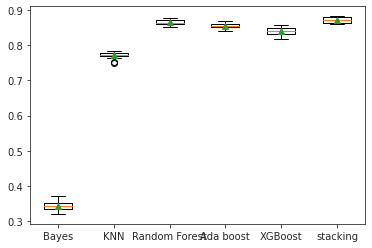

In [ ]:
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('Bayes', GNB))
	level0.append(('KNN', knn))
	level0.append(('Random Forest', rf))
	level0.append(('Ada Boost', ada))
	level0.append(('XGBoost', XGB))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['Bayes'] = GNB
	models['KNN'] = knn
	models['Random Forest'] = rf
	models['Ada boost'] = ada
	models['XGBoost'] = XGB
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_test, y_test)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Classification Scores 
         Model  Accuracy  Precision  Recall    F1
0  Hard Voting     0.946      0.969   0.945  0.95
1  Soft Voting     0.946      0.969   0.945  0.95 



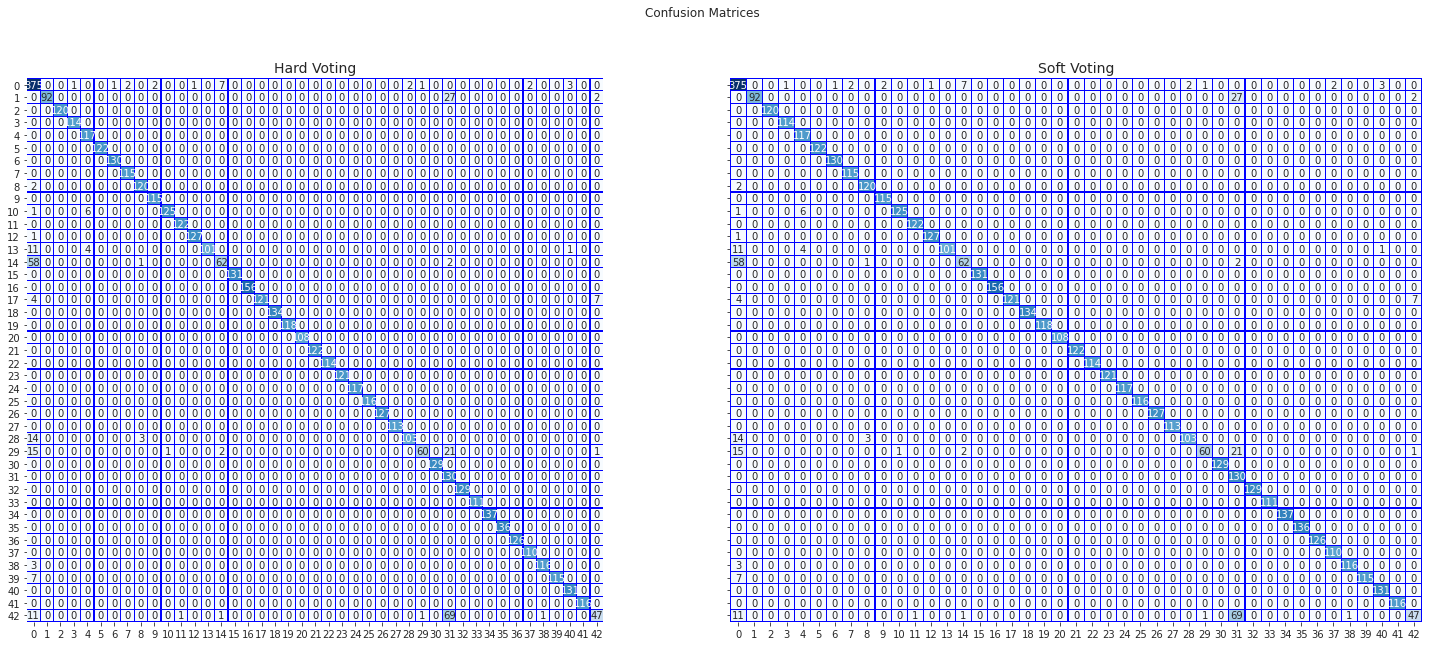

In [62]:
estimator = [('GNB',GNB),('KNN',knn),('RF',rf.best_estimator_),('Boost',ada),('XGB',XGB)]

vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X_train, y_train) 
vot_hard_pred = vot_hard.predict(X_test) 

vot_soft = VotingClassifier(estimators = estimator, voting ='soft') 
vot_soft.fit(X_train, y_train) 
vot_soft_pred = vot_hard.predict(X_test) 

fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios':[1,1.2]}, figsize=(25,10), sharey = True)
fig.suptitle('Confusion Matrices')

ax[0].set_title('Hard Voting', fontsize = 14)
df_vh = pd.DataFrame(metrics.confusion_matrix(y_test,vot_hard_pred))
sns.heatmap(df_vh, cmap="Blues", annot=True,annot_kws={"size": 10}, fmt = 'd', cbar = False, linewidths = 0.1, linecolor = 'Blue',vmin = 0, vmax = 200, ax=ax[0])


ax[1].set_title('Soft Voting', fontsize = 14)
df_vs = pd.DataFrame(metrics.confusion_matrix(y_test,vot_soft_pred))
sns.heatmap(df_vs, cmap="Blues", annot=True,annot_kws={"size": 10}, fmt = 'd', cbar = False, linewidths = 0.1, linecolor = 'Blue',vmin = 0, vmax = 200, ax=ax[1])


# printing the scores
v_scores = {'Model' : ['Hard Voting', 'Soft Voting'],
         'Accuracy' : [round(metrics.accuracy_score(y_test, vot_hard_pred),3),round(metrics.accuracy_score(y_test, vot_soft_pred),3)],
         'Precision' : [round(metrics.precision_score(y_test, vot_hard_pred,average='macro'),3),round(metrics.precision_score(y_test, vot_soft_pred,average='macro'),3)],
         'Recall' : [round(metrics.recall_score(y_test, vot_hard_pred,average='macro'),3),round(metrics.recall_score(y_test, vot_soft_pred,average='macro'),3)],
         'F1' : [round(metrics.f1_score(y_test, vot_hard_pred,average='macro'),3),round(metrics.f1_score(y_test, vot_soft_pred,average='macro'),3)]}

scores_vdf = pd.DataFrame(v_scores,columns = ['Model','Accuracy','Precision','Recall','F1'])

print(f'Classification Scores \n{scores_vdf} \n')

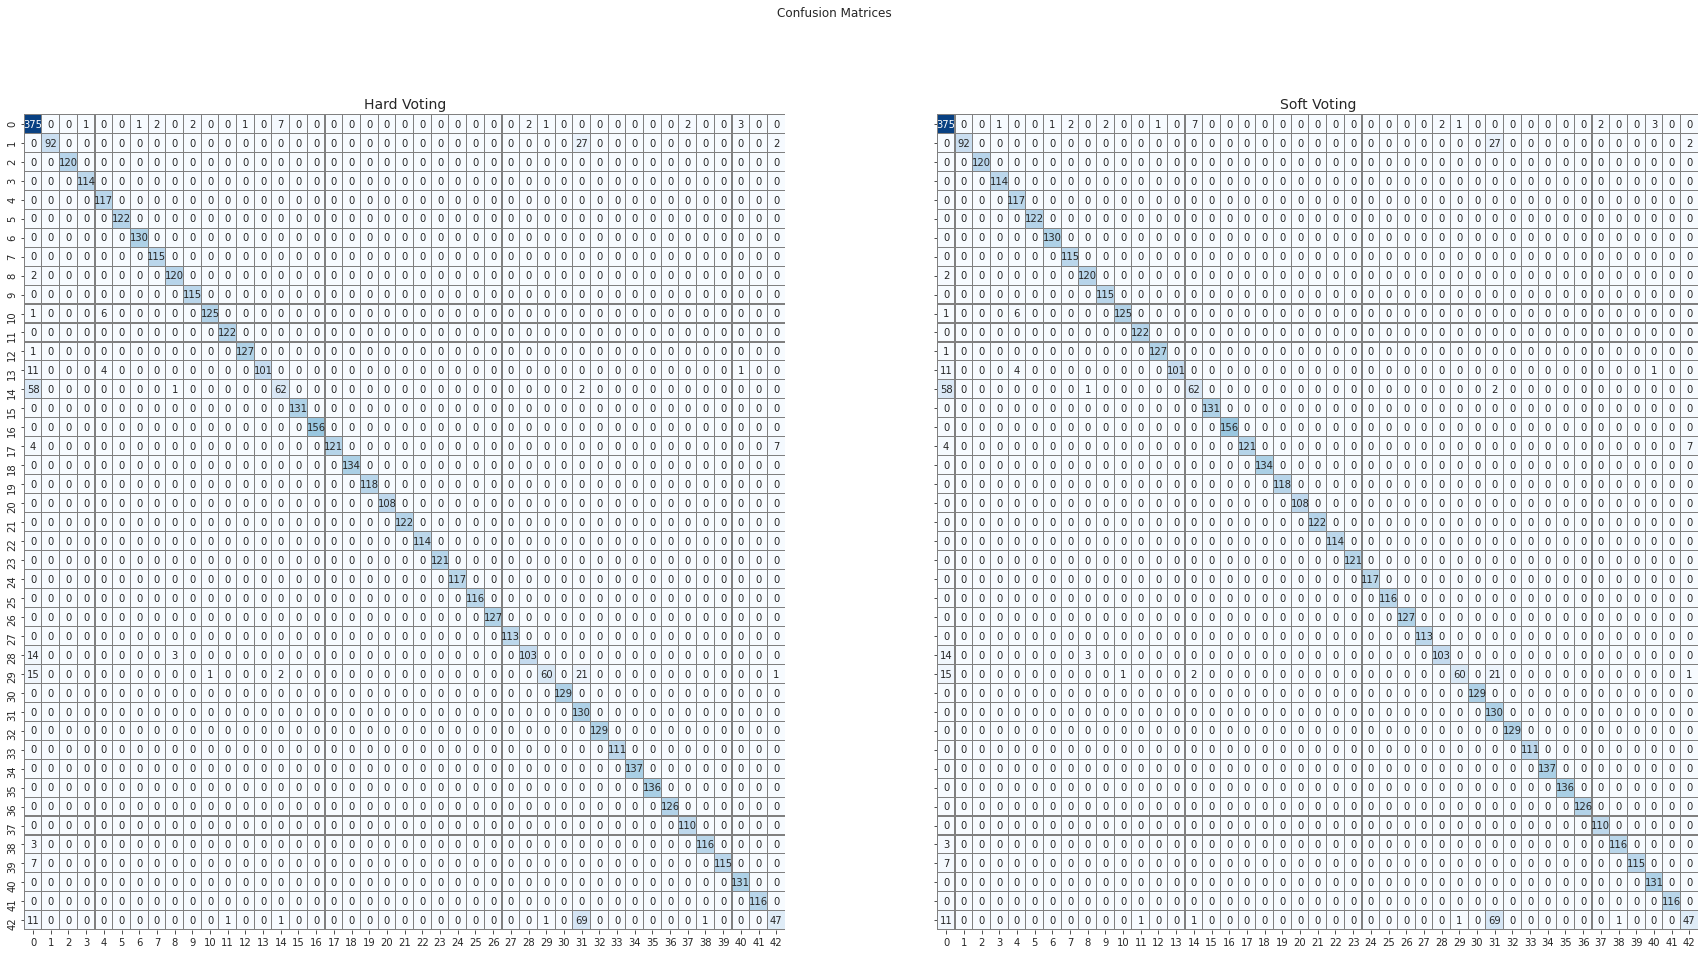

In [66]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios':[1.2,1.2]}, figsize=(30,15), sharey = True)
fig.suptitle('Confusion Matrices')

ax[0].set_title('Hard Voting', fontsize = 14)
df_vh = pd.DataFrame(metrics.confusion_matrix(y_test,vot_hard_pred))
sns.heatmap(df_vh, cmap="Blues", annot=True,annot_kws={"size": 10}, fmt = 'd', cbar = False, linewidths = 0.1, linecolor = 'Grey',vmin = 0, vmax = 400, ax=ax[0])


ax[1].set_title('Soft Voting', fontsize = 14)
df_vs = pd.DataFrame(metrics.confusion_matrix(y_test,vot_soft_pred))
sns.heatmap(df_vs, cmap="Blues", annot=True,annot_kws={"size": 10}, fmt = 'd', cbar = False, linewidths = 0.1, linecolor = 'Grey',vmin = 0, vmax = 400, ax=ax[1])


In [41]:
glove = '/content/drive/My Drive/Capstone/glove.6B.200d.txt'

embeddings = {}
for o in open(glove):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd

# create a weight matrix for words in training docs
glove_embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		glove_embedding_matrix[i] = embedding_vector

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44408, 200), (11102, 200), (44408, 43), (11102, 43))

In [45]:
# Using Glove embeddings

import keras as k
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout

init = k.initializers.glorot_uniform(seed = 1)
e_init = k.initializers.RandomUniform(-0.01, 0.01, seed = 1)

model = k.models.Sequential()

model.add(k.layers.Embedding(input_dim = num_words, input_length = maxlen, output_dim = 200, embeddings_initializer=k.initializers.Constant(glove_embedding_matrix), weights = [glove_embedding_matrix], trainable = False))
model.add(k.layers.Bidirectional(k.layers.LSTM(units = 128, kernel_initializer=init, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(k.layers.Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(k.layers.Flatten())
model.add(k.layers.Dense(units = 43, kernel_initializer=init, activation='softmax'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          3318800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          336896    
_________________________________________________________________
dense_2 (Dense)              (None, 200, 64)           16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 43)                550443    
Total params: 4,222,587
Trainable params: 903,787
Non-trainable params: 3,318,800
______________________________________

In [46]:
model.fit(X_train, y_train, epochs = 5, batch_size = 256)

Epoch 1/5
174/174 [==============================] - 194s 1s/step - loss: 2.0220 - acc: 0.4794
Epoch 2/5
174/174 [==============================] - 190s 1s/step - loss: 0.4515 - acc: 0.8619
Epoch 3/5
174/174 [==============================] - 190s 1s/step - loss: 0.3064 - acc: 0.9035
Epoch 4/5
174/174 [==============================] - 190s 1s/step - loss: 0.2404 - acc: 0.9203
Epoch 5/5
174/174 [==============================] - 190s 1s/step - loss: 0.2047 - acc: 0.9317


In [47]:
model_acc = model.evaluate(X_test, y_test, verbose = 1)

347/347 [==============================] - 26s 74ms/step - loss: 0.2087 - acc: 0.9347


#GRU Using Glove embeddings

In [48]:
gru = k.models.Sequential()

gru.add(k.layers.Embedding(input_dim = num_words, input_length = maxlen, output_dim = 200, embeddings_initializer=k.initializers.Constant(glove_embedding_matrix), weights = [glove_embedding_matrix], trainable = False))
gru.add(k.layers.GRU(units = 128, kernel_initializer=init, return_sequences=True, activation = 'relu', dropout=0.2))
gru.add(k.layers.GRU(units = 128, return_sequences=True, activation = 'relu', dropout=0.2))
gru.add(k.layers.Dense(units = 64, activation = 'relu'))
gru.add(Dropout(0.2))
gru.add(k.layers.Flatten())
gru.add(k.layers.Dense(units = 43, kernel_initializer=init, activation='softmax'))

gru.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

print(gru.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          3318800   
_________________________________________________________________
gru (GRU)                    (None, 200, 128)          126720    
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 128)          99072     
_________________________________________________________________
dense_4 (Dense)              (None, 200, 64)           8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 43)               

In [49]:
gru.fit(X_train, y_train, epochs = 3, batch_size = 256)

Epoch 1/3
174/174 [==============================] - 118s 664ms/step - loss: 2.3101 - acc: 0.4072
Epoch 2/3
174/174 [==============================] - 115s 660ms/step - loss: 0.5433 - acc: 0.8382
Epoch 3/3
174/174 [==============================] - 115s 663ms/step - loss: 0.3593 - acc: 0.8883


In [50]:
gru_acc = gru.evaluate(X_test, y_test, verbose = 1)

347/347 [==============================] - 17s 47ms/step - loss: 0.3046 - acc: 0.9093


# DL Model (LSTM) using Word2Vec Embedding

In [52]:
from gensim import models

w = '/content/drive/My Drive/Capstone/GoogleNews-vectors-negative300.bin'
w2v = models.KeyedVectors.load_word2vec_format(w, binary=True)

# create a weight matrix for words in training docs
w2v_embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
	if word in w2v.vocab:
		w2v_embedding_matrix[i] = w2v.word_vec(word)

In [53]:
import keras as k
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout

init = k.initializers.glorot_uniform(seed = 1)
e_init = k.initializers.RandomUniform(-0.01, 0.01, seed = 1)

model = k.models.Sequential()

model.add(k.layers.Embedding(input_dim = num_words, input_length = maxlen, output_dim = 300, embeddings_initializer=k.initializers.Constant(w2v_embedding_matrix), weights = [w2v_embedding_matrix], trainable = False))
model.add(k.layers.Bidirectional(k.layers.LSTM(units = 128, kernel_initializer=init, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(k.layers.Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(k.layers.Flatten())
model.add(k.layers.Dense(units = 43, kernel_initializer=init, activation='softmax'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          4978200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          439296    
_________________________________________________________________
dense_6 (Dense)              (None, 200, 64)           16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 43)                550443    
Total params: 5,984,387
Trainable params: 1,006,187
Non-trainable params: 4,978,200
____________________________________

In [54]:
model.fit(X_train, y_train, epochs = 3, batch_size = 256)

Epoch 1/3
174/174 [==============================] - 197s 1s/step - loss: 2.1989 - acc: 0.4284
Epoch 2/3
174/174 [==============================] - 194s 1s/step - loss: 0.5391 - acc: 0.8360
Epoch 3/3
174/174 [==============================] - 193s 1s/step - loss: 0.3712 - acc: 0.8816


In [55]:
w2v_acc = model.evaluate(X_test, y_test, verbose = 1)

347/347 [==============================] - 27s 77ms/step - loss: 0.3097 - acc: 0.8995


#CNN

In [56]:
cnn = Sequential()
cnn.add(k.layers.Embedding(num_words, 200, input_length=maxlen))
cnn.add(k.layers.Conv1D(128, 5, activation='relu'))
cnn.add(k.layers.Dropout(0.2))
cnn.add(k.layers.GlobalMaxPooling1D())
cnn.add(k.layers.Dense(64, activation='relu'))
cnn.add(k.layers.Dropout(0.2))
cnn.add(k.layers.Dense(43, activation='softmax'))

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(cnn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          3318800   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          128128    
_________________________________________________________________
dropout_4 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 43)               

In [57]:
cnn.fit(X_train, y_train, epochs = 3, batch_size = 256)

Epoch 1/3
174/174 [==============================] - 38s 57ms/step - loss: 2.6065 - accuracy: 0.4027
Epoch 2/3
174/174 [==============================] - 10s 56ms/step - loss: 0.2351 - accuracy: 0.9335
Epoch 3/3
174/174 [==============================] - 10s 57ms/step - loss: 0.1206 - accuracy: 0.9612


In [58]:
cnn_acc = cnn.evaluate(X_test, y_test, verbose = 1)

347/347 [==============================] - 1s 3ms/step - loss: 0.1212 - accuracy: 0.9568
